## Lab 04 Spectral Subtraction, Wiener filtering, end point detection, voice activity detection

### import packages, define anlaysis parameters and draw parameters, etc.

In [214]:
# import necessary packages
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt

# from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

In [215]:
# Ts : shift length in seconds. default 0.01sec = 10ms.
# Tf : frame length in seconds. default 0.02sec = 20ms.
# Fs = 16000 native sampling frequency ( wavfile에 정의된 것 )을 사용하면 필요없음.
Ts = 0.01
Tf = 0.02

# spectrum을 그리기 위한 parameters
cmap_plot = plt.cm.bone_r
FIG_SIZE = (8,3)

### 이전 Lab들에서 정의한 함수들

In [216]:
# draw spectrogram
from utils.gjdrawspectrogram3 import drawspectrogram3

In [217]:
# linear phase FIR filter design from magnitudes of the frequency components
from utils.gjfiroverlappadd import getLPHFIRFFT

In [218]:
# trapezoidal overlap add for FIR filtering
from utils.gjfiroverlappadd import firoverlapadd

### Load Speech and Noise
오디오 파일들의 경로 정의

In [219]:
auidoinputpath = './audio'
outpath = 'out'

# add '/' if path is not sa null string
def addpath(path, file):
    if len(path) == 0:
        return file
    else :
        return path + '/' + file

In [220]:
# 다음의 두 개의 파일을 이용하여 speech와 noise의 특성을 비교하여 본다.
speechfile = addpath(auidoinputpath, 'gjang-kdigits0-3.wav')
noisefile = addpath(auidoinputpath, 'car.wav')

load files in windows wav format
- librosa.load()는 -1 ~ 1
- 읽어들인 sampling frequency Fs를 이용하여 frame size Nf, shift size Ns를 계산한다.
- FFT(Fast Fourier Transform) 크기는 Nf보다 크거나 같은 2의 거듭제곱으로 FFT NFFT를 정의함. NFFT = 2^[log2(Nf)]

In [221]:
# load auido files with Librosa
# sr : target sampling, mono=True : convert signal to mono
speech, Fs = librosa.load(speechfile, sr=None, mono=True)
noise, _ = librosa.load(noisefile, sr=Fs, mono=True)

In [222]:
Ns = int(Fs*Ts) # shift number of samples
Nf = int(Fs*Tf) # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf)))) # Nf보다 크거나 같은 2의 거듭제곱을 NFFT로 정의
hNo = NFFT//2 + 1
print(f'Fs = {Fs}, Ns = {Ns}, Nf = {Nf}, NFFT = {NFFT}, hNo = {hNo}')

Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  0.98169835, -48.88611563,   3.1324693 , ...,  -9.12823462,
          2.7801733 ,   1.09309141],
       [ 15.65259614,  16.00577403,  16.22904319, ...,  13.82631938,
         15.76671355,  17.55505021],
       [ 15.55749858,  17.52033179,  17.45295515, ...,  18.98548141,
         19.86723635,  19.6122841 ],
       ...,
       [-68.11610281, -60.06479629, -62.70839477, ..., -49.39283694,
        -45.83500294, -56.26431093],
       [-54.83801771, -52.36526795, -56.37173569, ..., -50.60357958,
        -46.87544314, -60.39318112],
       [-66.43200604, -53.80243152, -73.95182647, ..., -48.89061985,
        -46.85413105, -52.25941962]])

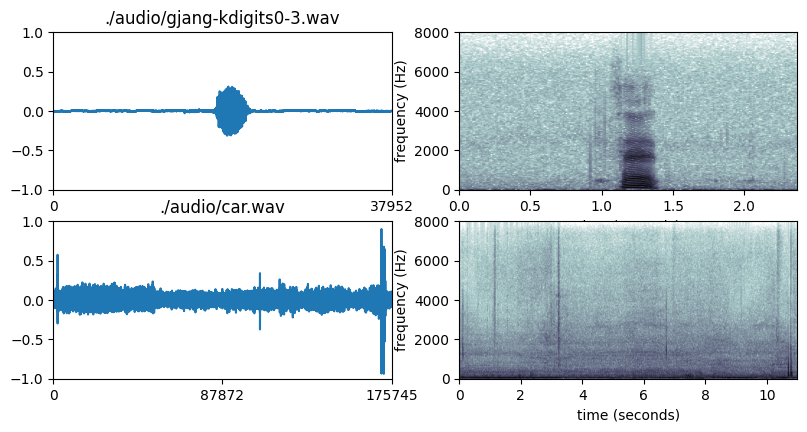

In [223]:
plt.figure(figsize=FIG_SIZE*np.array([1.2, 1.5]))
plt.subplot(2,2,1)
plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
plt.title(speechfile)

plt.subplot(2,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.subplot(2,2,3)
plt.plot(noise); plt.xlim(0, len(noise)); plt.ylim(-1,1); plt.xticks([0, len(noise)//2, len(noise)])
plt.title(noisefile)

plt.subplot(2,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

 Target SNR = 20 dB, gain = 0.1, Mixing SNR = 20.0
 Target SNR = 10 dB, gain = 0.31622776601683794, Mixing SNR = 10.0
 Target SNR = 0 dB, gain = 1.0, Mixing SNR = -5.177193784788869e-07
 Target SNR = -10 dB, gain = 3.1622776601683795, Mixing SNR = -10.0


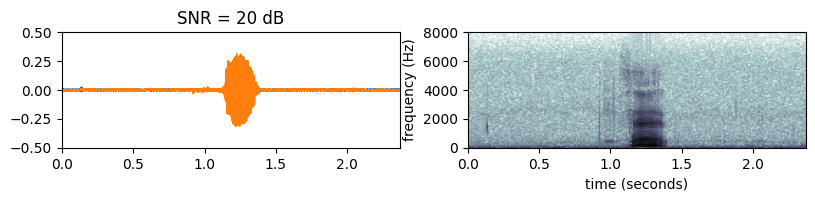

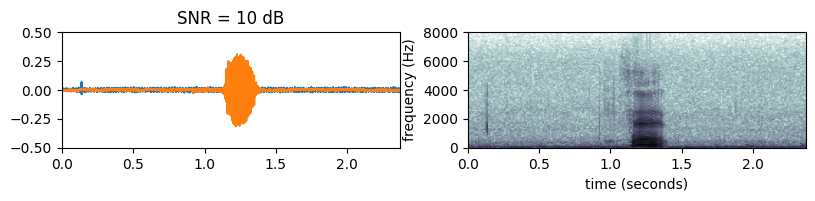

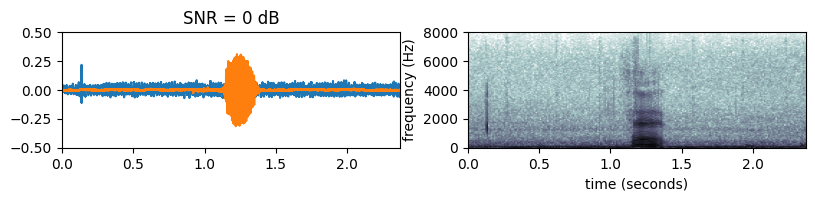

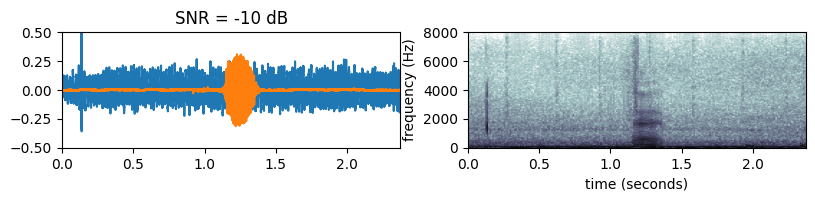

In [224]:
from utils import gjwavfile as wav

std_s = np.sqrt(np.mean(speech**2)) # speech의 표준편차
std_n = np.sqrt(np.mean(noise[:len(speech)]**2)) # noise의 표준편차
# SNR : signal to noise ratio, 각각 신호의 전력과 노이즈의 전력에 대한 비율. the power of Sig/the power of Noise
mixsnrs = np.array([20, 10, 0, -10]) # 각각의 SNR 값들을 numpy형태의 배열로 정의함.
mixedSig = [] # SNR에 따라서 섞을
mixedWavfiles = []
for snr in mixsnrs :
    gain = np.power(10, -snr/20)
    gn = noise[:len(speech)]/std_n*std_s*gain
    m = speech + gn
    mixedSig.append(m)
    print(f' Target SNR = {snr} dB, gain = {gain}, Mixing SNR = { 10*np.log10(np.sum(speech**2)/np.sum(gn**2)) }')

    # draw
    plt.figure(figsize=FIG_SIZE*np.array([1.2, 0.5]))
    plt.subplot(1,2,1)
    # plt.plot(speech)
    xscale = np.arange(len(gn))/Fs
    plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
    plt.title('SNR = %.0f dB' % (snr))
    plt.subplot(1,2,2)
    # plt.plot(noise)
    drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)
    
    # save the mixed file
    fname = addpath(outpath, 'mix%.fdb.wav'%(snr))
    wav.writewav(fname, Fs, m, maxval=1.0)
    mixedWavfiles.append(fname)

- 입력 음성 파일에 무음구간이 워낙 많기 때문에, 음성이 상대적으로 크게 들린다. 원래 0dB에서는 크기가 거의 같아야 한다.
- 제대로 SNR을 측정하기 위해서는 음성과 잡음의 무음 구간을 고려해야한다.

 Target SNR = -5 dB, gain = 1.7782794100389228, Mixing SNR = -13.82100224494934


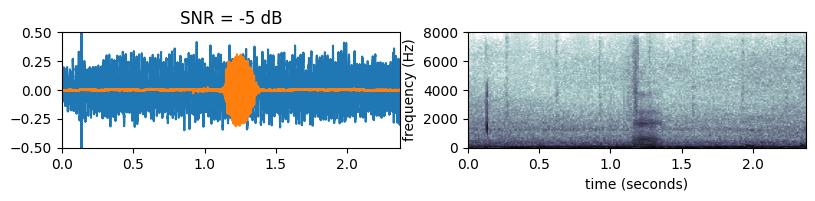

In [225]:
# 음성 존재구간을 tight하게 잡고 (1.1 ~ 1.4 sec) SNR = -5dB로 합성
tightinterval = (np.array([1.1, 1.4])*Fs).astype(int)
ss = speech[tightinterval[0]:tightinterval[1]]
nn = noise[tightinterval[0]:tightinterval[1]]

std_s = np.sqrt(np.mean(ss**2))
std_n = np.sqrt(np.mean(nn**2))
snr = -5 # SNR = -5dB
gain = np.sqrt(np.power(10, -snr/10))
gn = noise[:len(speech)]/std_n*std_s*gain
m = speech + gn
print(f' Target SNR = {snr} dB, gain = {gain}, Mixing SNR = { 10*np.log10(np.sum(speech**2)/np.sum(gn**2)) }')

# draw
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
xscale = np.arange(len(gn))/Fs
plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
plt.title('SNR = %.0f dB' % (snr))
plt.subplot(1,2,2)
_ = drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

# save the mixed file
fname = addpath(outpath, 'mixtight%.fdb.wav' % (snr))
wav.writewav(fname, Fs, m, maxval=1.0)
mixedWavfiles.append(fname)


- - - 
### Assignments : Spectral Subtraction and Wiener Filtering, End Point Detection
1. 각각의 SNR에 대해서 잡음을 앞의 0.5 구간에서 추정하고 이를 차감하는 FIR필터를 적용하여 잡음을 제거한다.
2. energy 기반 end point detection을 구현한다.
3. end point detection으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

### Solutions
1. 배경 잡음 제거하기
- 녹음 환경에서 추가되는 다양한 잡음들의 종류
    - 주변 환경 잡음 : 음악, 자동차, 사람 등
    - AC noise : 50 ~ 60Hz의 sinusiodal 잡음
    - DC noise : base level의 올라감
    - White noise : 백색잡음
- 가정
    - speech signal은 시간에 따라 주파수 특성이 바뀌며(non-statioinary) 항상 존재하지 않는다.
    - noise signal은 주파수 특성이 일정하다. (stationary)
    - noise-only 구간이 있다.

### Wiener Filter for Speech Enhancement
1. Notation Shift (in accordance with MAK's notation)
    - x(t). x|t|, X(w) : unobservable clean speech signal in continuous/discrete time and frequency domain
        - s(t), S(w) : 아래에서 사용하는 correlation의 Fourier Transform과 겹친다.
        - 엄밀히 정의하면 t는 continuous time을 의미하지만 x[t]로 쓰면 t가 discrete index라고 가정한다.(n을 쓰면 noise와 겹침).
    - y(t), y|t|, Y(w) : noisy, observated signal
    - n(t), n|t|, N(w) : underlying noise signal
    - X(k,w), Y(k,w), N(k,w) : frame k의 주파수 w 성분

2. Wiener Filter Deriviation

### Noise Spectrum Estimation in a fixed interval
1. noise는 stationary, speech는 non-stationary 가정
2. 처음 일정 시간은 noise만 있다고 가정하고 이 구간의 평균 spectral energy(|.|^2)을 추정
    - 아래 예제는 0 ~ 0.5 sec

In [226]:
def __sumSpect(x, I):
    Nt = I[1] - I[0]
    print(I[1], I[0])
    nframes = int((Nt-Nf)//Ns + 1)
    Sxx = np.zeros(hNo) # E[N*conj(N)]
    for n  in range(nframes) :
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 =(X*np.conj(X))
        Sxx += aX2[:hNo].real
    print(nframes)
    return Sxx, nframes

def estSpect(x, IntervalMulti=[]):

    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0,len(x)]])
        
    SxxSum = np.zeros(hNo)

    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Sxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        SxxSum = SxxSum + Sxx
        NumFrames += N
    return SxxSum/NumFrames

37952 0
236
8000 0
49
35200 32000
19


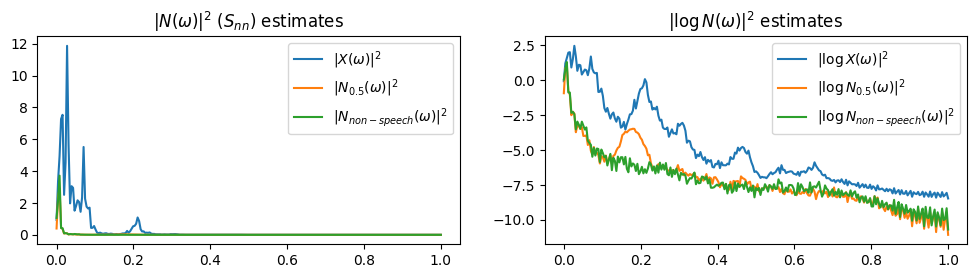

In [227]:
mix = mixedSig[1]
SyyAll = estSpect(mix, [])
SnnHead = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
#SnnEPD = estSpect(mix, np.array([[0, 1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)
SnnEPD = estSpect(mix, np.array([[2.0, 2.2]])*Fs)

plt.figure(figsize=FIG_SIZE*np.array([1.5, 0.9]))
xticks = np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,SyyAll,label='$|X(\omega)|^2$')
plt.plot(xticks,SnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,SnnEPD,label='$|N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,SxxEPD,label='$|S(\omega)|^2$')
plt.title('$|N(\omega)|^2$ ($S_{nn}$) estimates')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(xticks,np.log(SyyAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(SnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(SnnEPD),label='$|\log N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,np.log(SxxEPD),label='$|\log S(\omega)|^2$')
plt.title('$|\log N(\omega)|^2$ estimates')
plt.legend(loc='upper right')



- 0.5초로 추정한 |N(W)|^2이 전체 non-speech 구간에 매우 유사함을 알 수 있다.
- Wiener filter를 time domain FIR filter로 구하고 적용한다.
- 아래코드는 online processing을 염두에 두고한 shift(10ms) 처리하는 방식으로 구현되었다.
- plot Wiener filters

8000 0
49
8000 0
49
8000 0
49
8000 0
49


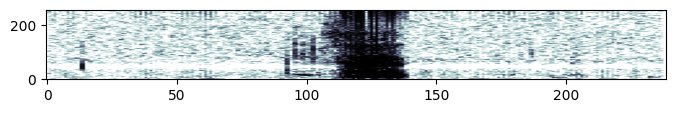

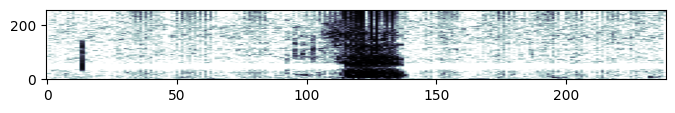

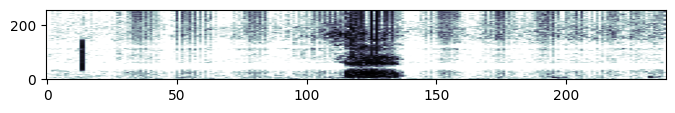

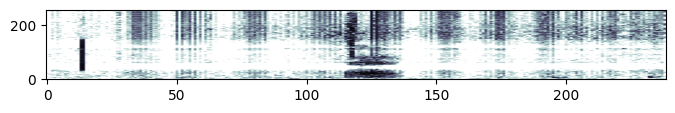

In [228]:
order = 30
noverlap = int(Fs*0.003) # 3ms
Nx = len(mix)

minwfgain = 10**(-20/20) # 0.1, gain의 상한을 정함.

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)


# overlap add를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []
for mix in mixedSig :
    Snn = estSpect(mix, np.array([[0.0, 0.5]])*Fs)

    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0 # time index
    H_a = np.zeros((hNo, 0)) # drawing
    while True :
        t1 = min(t, Nx) # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns, Nx) # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함.

        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii + Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = mix[t1+ii]
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Syy = aX2[:hNo].real
        Syy = np.maximum(1e-100, Syy) # to prevent divide by zero
        H = (Syy-Snn)/Syy
        H = np.maximum(minwfgain, H)

        H_a = np.column_stack([H_a, np.expand_dims(H, axis=1)])

        h,_ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l =fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout
        if l <= 0: break

        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns

    speechest.append(yout)
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.3]))
    plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower')    

- SNR이 작아질수록 non-speech 구간에서 Wiener Filter Gain이 커지는 것이 많다. 즉 noise가 많이 남게 됨.
- save noise Suppression Results in files
- compare before and after by SNR

        - linear phase Wiener filter with overlap-add를 하면 order + overlap 만큼의 delay가 발생한다.
        - noise suppressed signal을 shift하여 SNR을 계산한다.

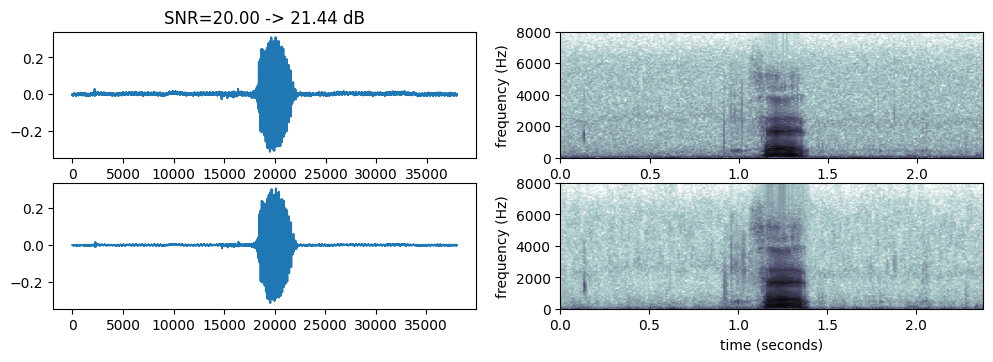

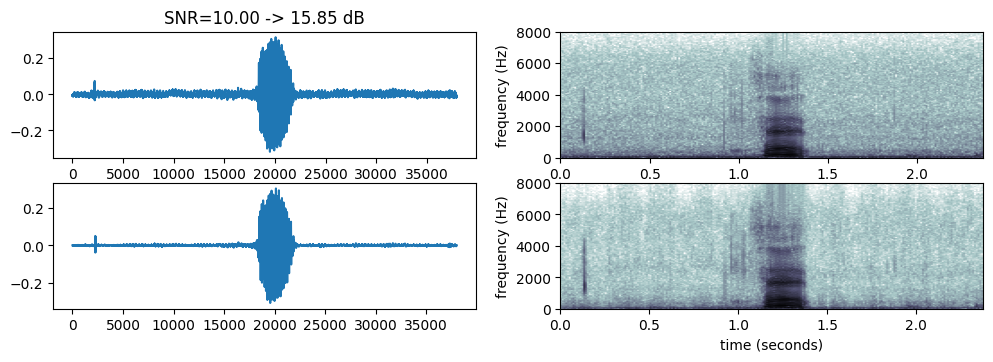

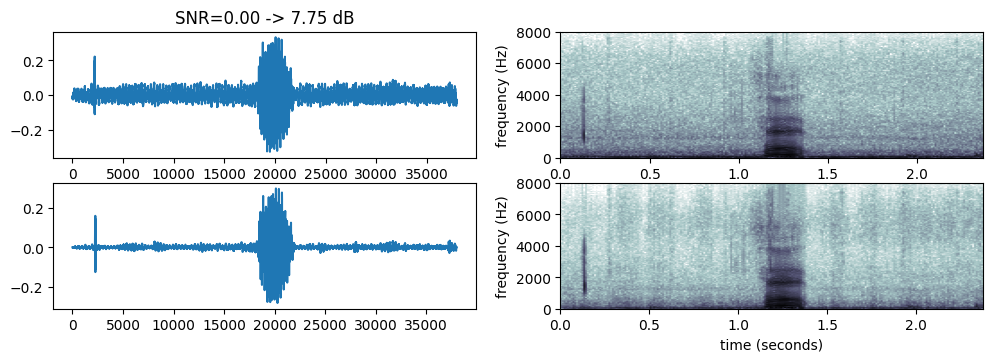

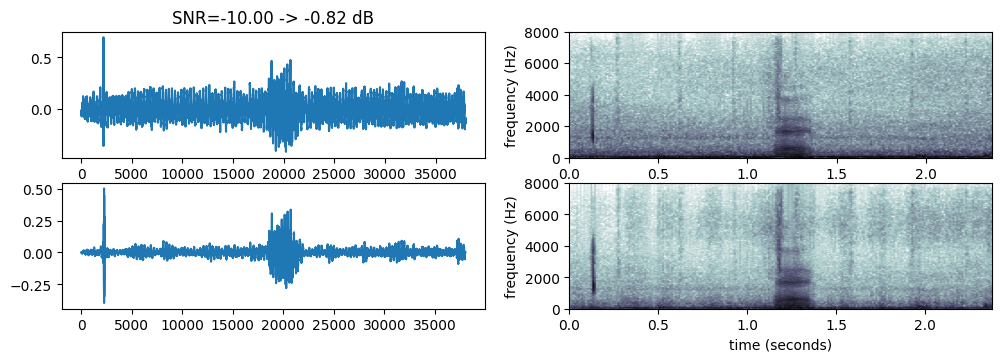

In [229]:
def getsnr(target, est):
    diff = np.sum((target-est)**2)
    diff = max(diff, 1e-30) # to prevent by zero
    return 10*(np.log10(np.sum(target**2))-np.log10(diff))

nsWavfiles = []
for m in range(len(mixedSig)):
    plt.figure(figsize=FIG_SIZE*np.array([1.5, 1.2]))
    plt.subplot(2,2,1)
    plt.plot(mixedSig[m])
    
    snrmix = getsnr(speech,mixedSig[m])
    snrest = getsnr(speech, speechest[m][fola.getDelay():])
    plt.title('SNR=%.2f -> %.2f dB' % (snrmix, snrest))
    plt.subplot(2,2,2)
    drawspectrogram3(mixedSig[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(2,2,3)
    plt.plot(speechest[m])
    plt.subplot(2,2,4)
    drawspectrogram3(speechest[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)

    # save the noise supperessed audio file
    fname = addpath(outpath, 'ns%.fdb.wav' % (mixsnrs[m]))
    wav.writewav(fname,Fs,speechest[m],maxval=1.0)
    nsWavfiles.append(fname)

- SNR improvement가 만족스럽진 않다. 이 예제가 저음이 강해서 대부분 잡음이 영향을 많이 주진 못한다.
- -10dB의 경우 음성의 왜곡이 많이 발생한다.
- mixed sound와 noise suppressed sound를 들어보자.

In [230]:
IPython.display.Audio(mixedWavfiles[0])

In [231]:
IPython.display.Audio(nsWavfiles[0])

In [232]:
IPython.display.Audio(mixedWavfiles[1])

In [233]:
IPython.display.Audio(nsWavfiles[1])

In [234]:
IPython.display.Audio(mixedWavfiles[2])

In [235]:
IPython.display.Audio(nsWavfiles[2])

In [236]:
IPython.display.Audio(mixedWavfiles[3])

In [237]:
IPython.display.Audio(nsWavfiles[3])

' 분석 결과 '

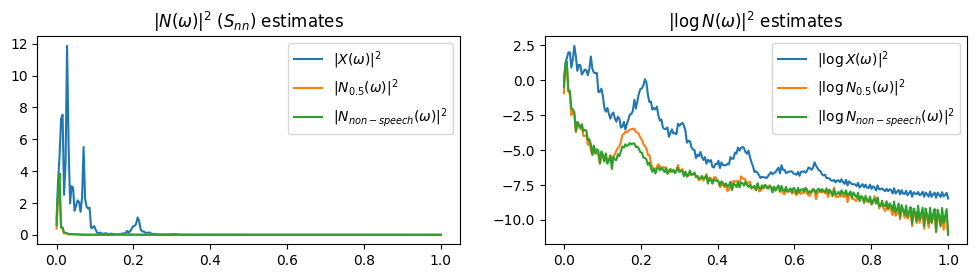

In [238]:
# Assignments 4 Solutions
# 1. 각각의 SNR에 대해서 잡음을 앞의 0.5초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.
# 2. Energy 기반 End Point Detection을 구현한다.
# 3. end point detection으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

""" noise는 stationary, speech는 non-stationary하다고 가정 """
""" 처음 일정 시간은 noise만 있다고 가정하고, 이 구간의 평균 spectral energy를 추정."""
### Exampels : 0 ~ 0.5 sec ###
### Spectral Summation #######
def __sumSpectral(x, I):
    # Nt : 해당 구간 샘플에서의 첫 인덱스와 다음 인덱스 사이의 interval 
    Nt = I[1] - I[0]
    
    # Nf : frame number of samples
    # nframes : 한 샘플당 frame들의 갯수
    nframes = int((Nt - Nf)//Ns + 1) 
    Sxx = np.zeros(hNo) # Sxx : E[N*conj(N)], 한 샘플에서의 Energy Distribution

    # for loop : 각 프레임당 Energy Density 계산.
    for n in range(nframes) :
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT) # FFT분석으로 신호를 뽑아냄.
        sqr_X = (X*np.conj(X))
        Sxx += sqr_X[:hNo].real

    return Sxx, nframes

### Spectral Estimation #######
def estSpectral(x, IntervalMulti=[]):
    # x : 1-dim time domain signal
    # IntervalMulti : 
    #   2-dim matrix, [n_interval, 2] : multiple intervals
    #   empty list : use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0,len(x)]]) # 한 샘플내에서의 프레임마다의 구간을 numpy 배열형태로 반영함.

    # accumulate interval power spectral densities
    Sum_Sxx = np.zeros(hNo) # E[N*conj(N)]
    
    NumFrames = 0 # 한 샘플의 Frame들의 갯수를 구하기 위한 파라미터
    for j in range(IntervalMulti.shape[0]) :
        [Sxx, N] = __sumSpectral(x, IntervalMulti[j,:].astype(int))
        Sum_Sxx = Sum_Sxx + Sxx
        NumFrames += N
    
    # average E[x*conj(x)]
    return Sum_Sxx/NumFrames

####################################
""" Example parameter definition """
mix2 = mixedSig[1]
SyyAll = estSpectral(mix2, [])
SnnEPD = estSpectral(mix2, np.array([[0, 1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)
# SnnEPD = estSpectral(mix2, np.array([[2.0, 2.2]])*Fs)
SnnHead = estSpectral(mix2, np.array([[0.0, 0.5]])*Fs)

""" Example plot """
plt.figure(figsize=FIG_SIZE*np.array([1.5, 0.9]))
xticks = np.linspace(0, 1, num=hNo, endpoint=True) # xticks : ?

# Speech and Noise Power Densities Estimation
plt.subplot(1,2,1)
plt.plot(xticks,SyyAll,label='$|X(\omega)|^2$')
plt.plot(xticks,SnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,SnnEPD,label='$|N_{non-speech}(\omega)|^2$')
plt.title('$|N(\omega)|^2$ ($S_{nn}$) estimates')
plt.legend(loc='upper right')

# Speech and Noise Power Densities Estimation in Log Scale
plt.subplot(1,2,2)
plt.subplot(1,2,2)
plt.plot(xticks,np.log(SyyAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(SnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(SnnEPD),label='$|\log N_{non-speech}(\omega)|^2$')
#plt.plot(xticks,np.log(SxxEPD),label='$|\log S(\omega)|^2$')
plt.title('$|\log N(\omega)|^2$ estimates')
plt.legend(loc='upper right')

""" 분석 결과 """
# 0.5초로 추정한 |N(w)|^2은 전체 non-speech 구간에서 매우 유사함을 알 수 있다.

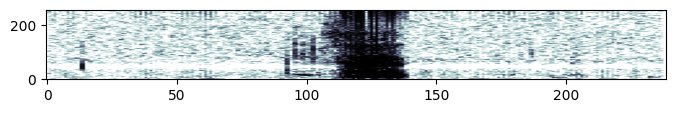

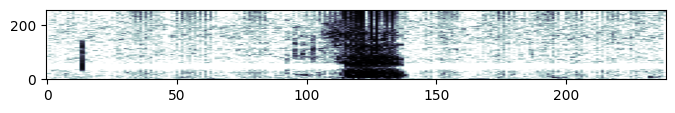

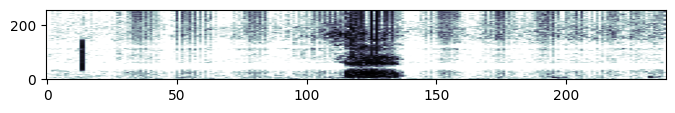

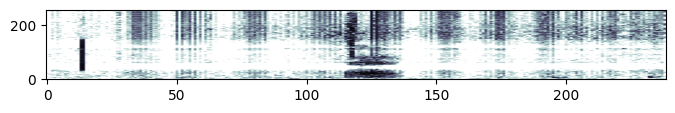

In [239]:
order = 30 # filter의 order 수. order가 증가할수록, smooth하게 필터링됨.
noverlap = int(Fs*0.003) # 3ms. overlap add할 때, 겹치는 길이
Nx = len(mix2) # mixedSig[1]의 전체 음성신호 길이 

minwfgain = 10**(-20/20) # 0.1, gain의 상한을 정함.

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)


# overlap add를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest2 = []
for mix in mixedSig :
    Snn = estSpectral(mix, np.array([[0.0, 0.5]])*Fs)

    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0 # time index
    H_a = np.zeros((hNo, 0)) # drawing
    while True :
        t1 = min(t, Nx) # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns, Nx) # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함.

        # Ns : shift number of samples
        # Nf : frame number of samples
        # sample에서 shift되고 난 다음, 겹치지 않는 부분을 buffer에 저장함.
        for i in range(Nf-Ns):
            xbuf[i] = xbuf[i + Ns]
        xbuf[(Nf-Ns):] = 0

        #  겹치지 않는 구간의 신호를 음성신호에서 채워넣음
        for i in range(t2-t1):
            xbuf[(Nf-Ns)+i] = mix[t1+i]
        X = np.fft.fft(xbuf, NFFT)

        sqr_X = (X*np.conj(X))
        Syy = sqr_X[:hNo].real
        Syy = np.maximum(1e-100, Syy) # to prevent divide by zero
        H = (Syy-Snn)/Syy
        H = np.maximum(minwfgain, H)

        H_a = np.column_stack([H_a, np.expand_dims(H, axis=1)])

        h,_ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l =fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout
        if l <= 0: break

        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns

    speechest2.append(yout)
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.3]))
    plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower') 

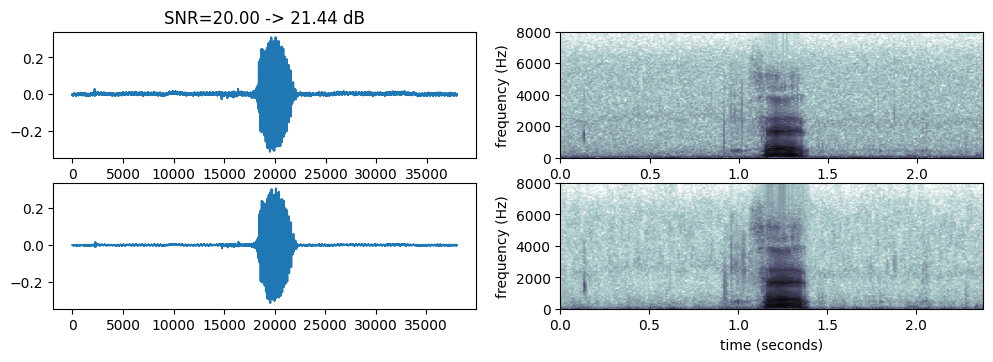

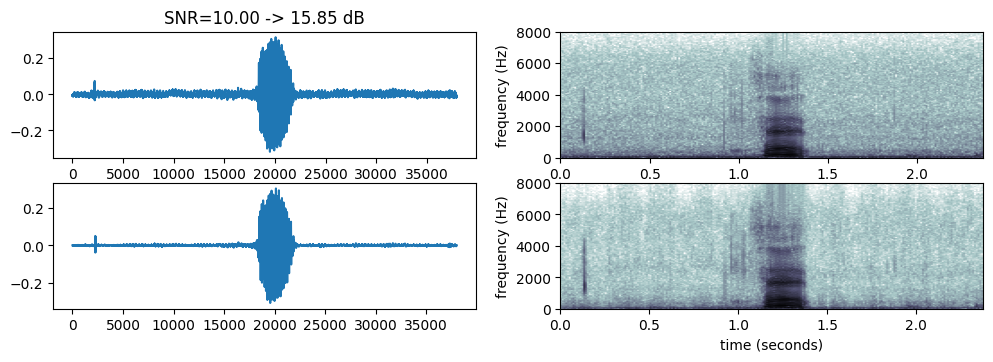

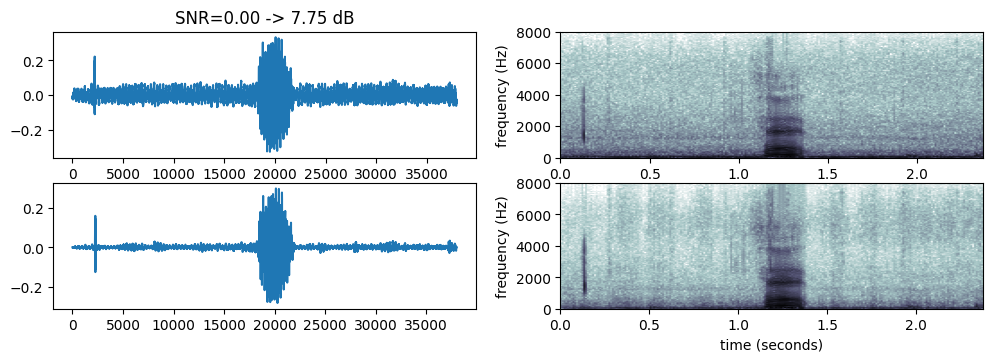

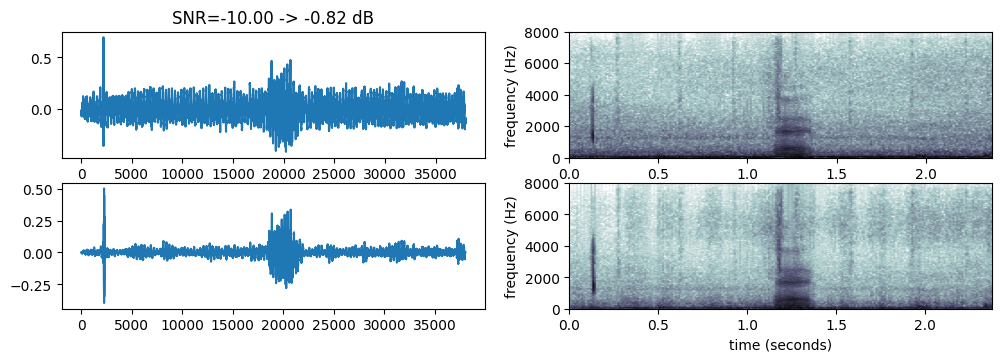

In [240]:
# SNR 값을 계산하기 위한 함수 
def getsnr(target, est):
    diff = np.sum((target-est)**2)
    diff = max(diff, 1e-30) # to prevent by zero
    return 10*(np.log10(np.sum(target**2))-np.log10(diff))

nsWavfiles = []
# 실제 음성과 추정한 SNR 비교
for m in range(len(mixedSig)):
    plt.figure(figsize=FIG_SIZE*np.array([1.5, 1.2]))
    plt.subplot(2,2,1)
    plt.plot(mixedSig[m])
    
    snrmix = getsnr(speech,mixedSig[m])
    snrest = getsnr(speech, speechest2[m][fola.getDelay():])
    plt.title('SNR=%.2f -> %.2f dB' % (snrmix, snrest))
    plt.subplot(2,2,2)
    drawspectrogram3(mixedSig[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(2,2,3)
    plt.plot(speechest2[m])
    plt.subplot(2,2,4)
    drawspectrogram3(speechest2[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)

    # save the noise supperessed audio file
    fname = addpath(outpath, 'ns%.fdb.wav' % (mixsnrs[m]))
    wav.writewav(fname,Fs,speechest2[m],maxval=1.0)
    nsWavfiles.append(fname)

In [241]:
""" Noise Spectrum Estimation with EPD(End Point Detection) """
# 1. noise는 stationary, speech는 non-stationary라고 가정
# 2. 각각의 SNR에 대해서, 처음 일정시간은 noise만 있따고 가정하고 이 구간의 평균 Spectral energy를 추정

# Example   : EPD로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정
#           : 각 Frame에서 잡음 스펙트럼을 차감하는 FIR Wiener 필터를 적용하여 잡음을 제거한다.

# 1) 입력신호의 frame 별 absolute Energy를 구함.
    
# 2) initial thresholding 적당한 값을 정해 voice/unvocie인지 알려주는 indicator function을 설계한다.

# 3) indicator 함수에 대해서 median filter 또는 적절한 smoothing을 해준다. (3 ~ 5 프레임 정도)

# 4) indicator 함수에서 연속된 구간의 길이가 일정 길이 이상일때만 vocie로 판정한다.(보통 100 ~ 300ms)

# 5) 앞뒤로 extension ( 무성 자음과 fading-out 포함 )

# 6) 수식 : all summation of (1-I[k])*|N(w)|^2 / (1-I[k]) about k


' Noise Spectrum Estimation with EPD(End Point Detection) '

In [242]:
# 사용할 함수들 정의

# 
def get_energy(x, Ts, Tf, I, Fs):
    # x : speech signal
    Ns = int(Ts*Fs) # Ns : shift number of samples
    Nf = int(Tf*Fs) # Nf : Frame nubmer of samples
    # Nt = int(Tn*Fs) # Nn : noise number of samples, 앞선 것과는 다르게 임의의로 Tn은 0.5으로 잡아줌.
    Nt = I[1] - I[0]  

    # NFFT : # Nf보다 크거나 같은 2의 거듭제곱을 NFFT로 정의
    NFFT = int(2**(np.ceil(np.log2(Nf))))
    hNo = NFFT//2 + 1 # hNo : 
    Pnn = np.zeros(hNo) # Pnn : E[N*conj(N)]
    nframes = int((Nt-Nf)//Ns + 1) # nframes : 한 샘플당 전체 프레임의 갯수

    for n in range(nframes):
        y = x[(n*Ns):(n*Ns)+Nf]
        Y = np.fft.fft(y, NFFT)
        sqr_Y = (Y*np.conj(Y))
        Pnn += sqr_Y[:hNo].real

    return Pnn/nframes

